# 06 - External Rankings Comparison

Compare our 2026 projections to external rankings (ESPN or FantasyPros).

## Getting Rankings

### Option 1: ESPN PDF (Easiest)
Download ESPN's Top 300 cheat sheet PDF and place it in `data/espn/`. This notebook will parse it automatically.

```bash
pip install pymupdf  # Required for PDF parsing
```

### Option 2: FantasyPros 
FantasyPros aggregates rankings from multiple experts including ESPN's Tristan Cockcroft.

```bash
pip install selenium
python scripts/scrape_rankings.py fantasypros
```

### Option 3: ESPN Manual Entry
Fill in `data/espn/espn_rankings_template.csv` and save as `data/espn/espn_rankings_2026.csv`

In [69]:
import sys
import os
import re

# Set working directory to project root
if 'notebooks' in os.getcwd():
    os.chdir('..')
sys.path.insert(0, os.getcwd())

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Check for PyMuPDF
try:
    import fitz  # PyMuPDF
    PYMUPDF_AVAILABLE = True
except ImportError:
    PYMUPDF_AVAILABLE = False

print(f"Project root: {os.getcwd()}")
print(f"PyMuPDF available: {PYMUPDF_AVAILABLE}")

Project root: /Users/matthewgillies/mlb-fantasy-2026
PyMuPDF available: True


In [70]:
# PDF Parsing Functions
def parse_espn_pdf(pdf_path):
    """
    Parse ESPN Top 300 PDF and extract player rankings with team and position.
    
    ESPN PDF format (multi-column, interleaved):
    RANK. Player Name
    TEAM
    POSITION
    $VALUE
    """
    if not PYMUPDF_AVAILABLE:
        print("PyMuPDF not installed. Install with: pip install pymupdf")
        return None
    
    print(f"Parsing PDF: {pdf_path}")
    
    # Extract text from PDF
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text()
    doc.close()
    
    # First pass: Get all players with names
    pattern_name = r'(\d{1,3})\.\s+([A-Za-z][A-Za-z\'\-\.\s]+?)(?=\n)'
    matches_name = re.findall(pattern_name, text)
    
    # Build dict of all players
    players_dict = {}
    for rank_str, name in matches_name:
        rank = int(rank_str)
        name = re.sub(r'\s+', ' ', name.strip())
        if len(name) >= 3 and not name.isupper() and 1 <= rank <= 300 and rank not in players_dict:
            players_dict[rank] = {'ESPN_Rank': rank, 'Name': name, 'Team': '', 'Position': ''}
    
    # Second pass: Find team and position for each player
    for rank, player in players_dict.items():
        name = player['Name']
        name_escaped = re.escape(name)
        # Look for: RANK. Name followed by team and position on next lines
        pattern = rf'{rank}\.\s+{name_escaped}\n([A-Z]{{2,3}}|FA)\n([A-Z0-9/]+)'
        match = re.search(pattern, text)
        if match:
            player['Team'] = match.group(1)
            player['Position'] = match.group(2)
    
    if not players_dict:
        print("Could not parse rankings from PDF")
        with open('data/espn/espn_pdf_text.txt', 'w') as f:
            f.write(text)
        print("Raw text saved to data/espn/espn_pdf_text.txt for manual review")
        return None
    
    df = pd.DataFrame(players_dict.values())
    df = df.sort_values('ESPN_Rank').reset_index(drop=True)
    
    print(f"Parsed {len(df)} players")
    
    # Stats
    with_team = (df['Team'] != '').sum()
    with_pos = (df['Position'] != '').sum()
    print(f"  With team: {with_team}, With position: {with_pos}")
    
    # Warn if missing ranks
    missing = set(range(1, 301)) - set(players_dict.keys())
    if missing:
        print(f"Warning: Missing ranks {sorted(missing)[:10]}{'...' if len(missing) > 10 else ''}")
    
    return df

print("PDF parsing functions loaded")

PDF parsing functions loaded


## Load Our Predictions

In [71]:
# Load our rankings (now includes Position)
our_rankings = pd.read_csv('predictions/overall_2026_rankings.csv')
print(f"Loaded {len(our_rankings)} players from our rankings")
print(f"Columns: {our_rankings.columns.tolist()}")
print()
print(our_rankings.head(15).to_string(index=False))

Loaded 1003 players from our rankings
Columns: ['Overall_Rank', 'Name', 'Team', 'Position', 'Type', 'Projected_Fpoints']

 Overall_Rank                  Name Team Position   Type  Projected_Fpoints
            1          Tarik Skubal  DET       SP     SP         528.746334
            2             Juan Soto  NYM       OF Batter         518.967040
            3       Garrett Crochet  BOS       SP     SP         500.188436
            4           Aaron Judge  NYY    OF/DH Batter         495.305922
            5         Shohei Ohtani  LAD    DH/SP Batter         470.785143
            6          Jose Ramirez  CLE    3B/DH Batter         462.166119
            7        Bobby Witt Jr.  KCR       SS Batter         454.145205
            8         Hunter Greene  CIN       SP     SP         448.081748
            9           Paul Skenes  PIT       SP     SP         438.244678
           10           Cole Ragans  KCR       SP     SP         435.930805
           11           Dylan Cease  TOR  

## Load ESPN Rankings

In [72]:
# Create ESPN data directory
os.makedirs('data/espn', exist_ok=True)

# File paths
FANTASYPROS_FILE = 'data/espn/fantasypros_rankings_2026.csv'
ESPN_FILE = 'data/espn/espn_rankings_2026.csv'

external_rankings = None
rankings_source = None

# Check for PDF and re-parse if available (to ensure we get all 300 players)
pdf_files = [f for f in os.listdir('data/espn') if f.endswith('.pdf')]

if pdf_files and PYMUPDF_AVAILABLE:
    pdf_path = os.path.join('data/espn', pdf_files[0])
    print(f"Found PDF: {pdf_path}")
    
    parsed = parse_espn_pdf(pdf_path)
    
    if parsed is not None and len(parsed) > 0:
        # Save parsed results
        parsed.to_csv(ESPN_FILE, index=False)
        print(f"Saved parsed rankings to {ESPN_FILE}")
        
        external_rankings = parsed.rename(columns={'ESPN_Rank': 'External_Rank'})
        rankings_source = 'ESPN'
        
        print(f"\nFirst 10 parsed players:")
        print(external_rankings.head(10).to_string(index=False))

# Fallback: Check for existing CSV files if PDF parsing didn't work
if external_rankings is None:
    if os.path.exists(FANTASYPROS_FILE):
        external_rankings = pd.read_csv(FANTASYPROS_FILE)
        rankings_source = 'FantasyPros'
        if 'FP_Rank' in external_rankings.columns:
            external_rankings = external_rankings.rename(columns={'FP_Rank': 'External_Rank'})
        print(f"Loaded FantasyPros rankings: {len(external_rankings)} players")
        
    elif os.path.exists(ESPN_FILE):
        external_rankings = pd.read_csv(ESPN_FILE)
        rankings_source = 'ESPN'
        if 'ESPN_Rank' in external_rankings.columns:
            external_rankings = external_rankings.rename(columns={'ESPN_Rank': 'External_Rank'})
        print(f"Loaded ESPN rankings: {len(external_rankings)} players")

# Summary
if external_rankings is not None:
    print(f"\nSource: {rankings_source}")
    print(f"Total players: {len(external_rankings)}")
else:
    print("No external rankings found.")
    print(f"\nTo add rankings:")
    print(f"  1. Place ESPN Top 300 PDF in data/espn/ (requires: pip install pymupdf)")
    print(f"  2. Or run: python scripts/scrape_rankings.py fantasypros")
    print(f"  3. Or fill in: data/espn/espn_rankings_template.csv")

Found PDF: data/espn/espn_top_300.pdf
Parsing PDF: data/espn/espn_top_300.pdf
Parsed 300 players
  With team: 300, With position: 300
Saved parsed rankings to data/espn/espn_rankings_2026.csv

First 10 parsed players:
 External_Rank               Name Team Position
             1      Shohei Ohtani  LAD    DH/SP
             2        Aaron Judge  NYY    OF/DH
             3        Paul Skenes  PIT       SP
             4          Juan Soto  NYM       OF
             5       Tarik Skubal  DET       SP
             6       Jose Ramirez  CLE    3B/DH
             7    Garrett Crochet  BOS       SP
             8     Bobby Witt Jr.   KC       SS
             9        Kyle Tucker  LAD       OF
            10 Yoshinobu Yamamoto  LAD       SP

Source: ESPN
Total players: 300


## Name Matching

ESPN and FanGraphs may use slightly different name formats. We'll use fuzzy matching to align them.

In [73]:
from difflib import SequenceMatcher

def fuzzy_match_name(name, candidates, threshold=0.85):
    """Find best matching name from candidates."""
    best_match = None
    best_score = 0
    
    name_lower = name.lower().strip()
    
    for candidate in candidates:
        candidate_lower = candidate.lower().strip()
        
        # Exact match
        if name_lower == candidate_lower:
            return candidate, 1.0
        
        # Fuzzy match
        score = SequenceMatcher(None, name_lower, candidate_lower).ratio()
        if score > best_score:
            best_score = score
            best_match = candidate
    
    if best_score >= threshold:
        return best_match, best_score
    return None, 0

print("Fuzzy matching function ready")

Fuzzy matching function ready


In [74]:
if external_rankings is not None:
    # Match external names to our names
    our_names = our_rankings['Name'].tolist()
    
    matches = []
    unmatched = []
    
    for idx, row in external_rankings.iterrows():
        ext_name = row['Name']
        matched_name, score = fuzzy_match_name(ext_name, our_names)
        
        if matched_name:
            matches.append({
                'External_Name': ext_name,
                'Our_Name': matched_name,
                'Match_Score': score,
                'External_Rank': row['External_Rank']
            })
        else:
            unmatched.append(ext_name)
    
    matches_df = pd.DataFrame(matches)
    print(f"Matched {len(matches_df)} of {len(external_rankings)} {rankings_source} players")
    print(f"Unmatched: {len(unmatched)}")
    
    if unmatched:
        print(f"\nFirst 20 unmatched names:")
        print(unmatched[:20])
else:
    print("External rankings not loaded - skipping matching")
    matches_df = None

Matched 291 of 300 ESPN players
Unmatched: 9

First 20 unmatched names:
['Trey Yesavage', 'Tatsuya Imai', 'Kazuma Okamoto', 'Joe Musgrove', 'Gerrit Cole', 'Shane McClanahan', 'Munetaka Murakami', 'Cody Ponce', 'Robert Stephenson']


## Merge Rankings

In [75]:
if matches_df is not None:
    # Merge external ranks with our rankings
    comparison = our_rankings.merge(
        matches_df[['Our_Name', 'External_Rank']],
        left_on='Name',
        right_on='Our_Name',
        how='left'
    )
    comparison = comparison.drop('Our_Name', axis=1)
    
    # Impute rank 300 for players not in ESPN rankings
    # This allows us to calculate rank differences for all players
    comparison['External_Rank'] = comparison['External_Rank'].fillna(300)
    
    # Calculate rank difference (positive = we rank higher than external)
    comparison['Rank_Diff'] = comparison['External_Rank'] - comparison['Overall_Rank']
    
    # Track which players were in ESPN vs imputed
    comparison['In_ESPN'] = comparison['External_Rank'] < 300
    
    # Stats
    in_espn = comparison['In_ESPN'].sum()
    imputed = len(comparison) - in_espn
    print(f"Players matched to ESPN: {in_espn}")
    print(f"Players imputed as rank 300: {imputed}")
    
    # For analysis, we can use all players now
    both = comparison.copy()
    print(f"Total players for comparison: {len(both)}")
else:
    comparison = our_rankings.copy()
    comparison['External_Rank'] = 300
    comparison['Rank_Diff'] = 300 - comparison['Overall_Rank']
    comparison['In_ESPN'] = False
    both = comparison

Players matched to ESPN: 292
Players imputed as rank 300: 711
Total players for comparison: 1003


## Rankings Comparison Analysis

In [76]:
if external_rankings is not None and len(both) > 0:
    print(f"=== Rank Correlation ({rankings_source}) ===")
    corr = both['Overall_Rank'].corr(both['External_Rank'])
    print(f"Pearson correlation: {corr:.3f}")
    
    spearman = both['Overall_Rank'].corr(both['External_Rank'], method='spearman')
    print(f"Spearman correlation: {spearman:.3f}")
else:
    print("Need external rankings for correlation analysis")

=== Rank Correlation (ESPN) ===
Pearson correlation: 0.697
Spearman correlation: 0.747


In [77]:
# Players we value HIGHER than external rankings (potential sleepers)
if external_rankings is not None and len(both) > 0:
    sleepers = both[both['Rank_Diff'] > 20].sort_values('Rank_Diff', ascending=False)
    
    print(f"\n=== SLEEPERS (We Rank Higher Than {rankings_source}) ===")
    print(f"(Positive Rank_Diff = {rankings_source} undervalues)")
    print(f"(External_Rank=300 means not in ESPN top 300)")
    display_cols = ['Name', 'Team', 'Position', 'Overall_Rank', 'External_Rank', 'Rank_Diff', 'Projected_Fpoints']
    print(sleepers[display_cols].head(30).to_string(index=False))
    
    # Highlight players not in ESPN at all that we have ranked highly
    not_in_espn = both[(both['External_Rank'] == 300) & (both['Overall_Rank'] <= 150)]
    if len(not_in_espn) > 0:
        print(f"\n=== DEEP SLEEPERS (Not in ESPN 300, Our Top 150) ===")
        not_in_espn = not_in_espn.sort_values('Overall_Rank')
        print(not_in_espn[['Name', 'Team', 'Position', 'Overall_Rank', 'Projected_Fpoints']].head(20).to_string(index=False))
else:
    print("Need external rankings for sleeper analysis")


=== SLEEPERS (We Rank Higher Than ESPN) ===
(Positive Rank_Diff = ESPN undervalues)
(External_Rank=300 means not in ESPN top 300)
              Name Team Position  Overall_Rank  External_Rank  Rank_Diff  Projected_Fpoints
       Luis Arraez  SFG    1B/DH            77          294.0      217.0         329.056145
    Nolan Schanuel  LAA       1B            88          300.0      212.0         321.389649
   Jonathan Aranda  TBR       1B           112          300.0      188.0         311.037716
        Masyn Winn  STL       SS           118          300.0      182.0         308.366759
        Yandy Diaz  TBR    1B/DH            44          221.0      177.0         352.448573
    Ezequiel Tovar  COL       SS           141          300.0      159.0         297.982639
     Luis Severino  ATH       SP           145          300.0      155.0         296.078985
    Brandon Pfaadt  ARI       SP           146          300.0      154.0         296.019386
      Reid Detmers  LAA       RP         

In [78]:
# Players external rankings value HIGHER than us (potential busts / overvalued)
if external_rankings is not None and len(both) > 0:
    busts = both[both['Rank_Diff'] < -20].sort_values('Rank_Diff', ascending=True)
    
    print(f"\n=== OVERVALUED BY {rankings_source.upper()} (We Rank Lower) ===")
    print(f"(Negative Rank_Diff = {rankings_source} overvalues)")
    display_cols = ['Name', 'Team', 'Position', 'Overall_Rank', 'External_Rank', 'Rank_Diff', 'Projected_Fpoints']
    print(busts[display_cols].head(25).to_string(index=False))
else:
    print("Need external rankings for bust analysis")


=== OVERVALUED BY ESPN (We Rank Lower) ===
(Negative Rank_Diff = ESPN overvalues)
             Name  Team Position  Overall_Rank  External_Rank  Rank_Diff  Projected_Fpoints
       Ian Gibaut   CIN       RP          1003          300.0     -703.0           1.335359
     Tayler Scott   ATL       RP          1002          300.0     -702.0           1.496971
         Sam Long   KCR       RP          1001          300.0     -701.0           1.660501
    Jose Castillo - - -       RP          1000          300.0     -700.0           1.815428
   Chris Stratton - - -       RP           999          300.0     -699.0           1.830816
   Emmanuel Clase   CLE       RP           998          300.0     -698.0           1.864131
    Sean Reynolds   SDP       SP           997          300.0     -697.0           1.903127
  Eduardo Salazar   WSN       RP           996          300.0     -696.0           1.934575
      Nic Enright   TOR       RP           995          300.0     -695.0           1.9524

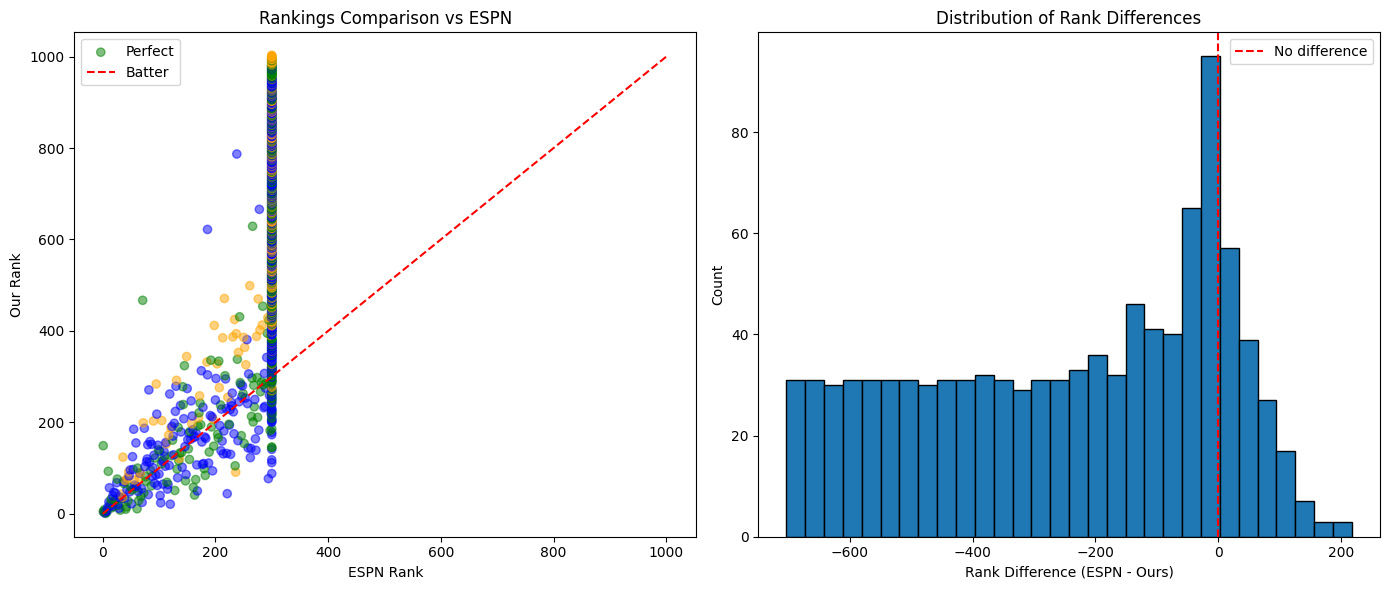

In [79]:
# Visualization: Our rank vs external rank
if external_rankings is not None and len(both) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Create position category for coloring
    def get_pos_category(pos):
        if pd.isna(pos) or pos == 'Unknown':
            return 'Unknown'
        if pos in ['SP', 'RP'] or 'SP' in pos or 'RP' in pos:
            return 'SP' if 'SP' in pos else 'RP'
        return 'Batter'
    
    both['Pos_Category'] = both['Position'].apply(get_pos_category)
    
    # Scatter plot
    ax = axes[0]
    colors = both['Pos_Category'].map({'Batter': 'blue', 'SP': 'green', 'RP': 'orange', 'Unknown': 'gray'})
    ax.scatter(both['External_Rank'], both['Overall_Rank'], c=colors, alpha=0.5)
    
    # Perfect agreement line
    max_rank = max(both['External_Rank'].max(), both['Overall_Rank'].max())
    ax.plot([0, max_rank], [0, max_rank], 'r--', label='Perfect agreement')
    
    ax.set_xlabel(f'{rankings_source} Rank')
    ax.set_ylabel('Our Rank')
    ax.set_title(f'Rankings Comparison vs {rankings_source}')
    ax.legend(['Perfect', 'Batter', 'SP', 'RP'])
    
    # Distribution of rank differences
    ax = axes[1]
    ax.hist(both['Rank_Diff'].dropna(), bins=30, edgecolor='black')
    ax.axvline(x=0, color='red', linestyle='--', label='No difference')
    ax.set_xlabel(f'Rank Difference ({rankings_source} - Ours)')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Rank Differences')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("Need external rankings for visualization")

## Position-Specific Analysis

In [80]:
# Analyze by position
if external_rankings is not None and len(both) > 0:
    # Create primary position for analysis
    def get_primary_pos(pos):
        if pd.isna(pos) or pos == 'Unknown':
            return 'Unknown'
        return pos.split('/')[0]
    
    both['Primary_Pos'] = both['Position'].apply(get_primary_pos)
    
    print(f"\n=== Rank Differences by Position ({rankings_source}) ===")
    
    # Group positions
    pos_groups = {
        'C': ['C'],
        '1B': ['1B'],
        '2B': ['2B'],
        '3B': ['3B'],
        'SS': ['SS'],
        'OF': ['OF', 'LF', 'CF', 'RF'],
        'DH': ['DH'],
        'SP': ['SP'],
        'RP': ['RP']
    }
    
    for pos_name, pos_list in pos_groups.items():
        subset = both[both['Primary_Pos'].isin(pos_list)]
        if len(subset) > 0:
            mean_diff = subset['Rank_Diff'].mean()
            std_diff = subset['Rank_Diff'].std()
            print(f"{pos_name}: Mean diff = {mean_diff:+.1f}, Std = {std_diff:.1f}, n = {len(subset)}")
else:
    print("Need external rankings for position analysis")


=== Rank Differences by Position (ESPN) ===
C: Mean diff = -282.5, Std = 217.2, n = 66
1B: Mean diff = -190.6, Std = 277.0, n = 55
2B: Mean diff = -248.1, Std = 234.1, n = 60
3B: Mean diff = -246.8, Std = 245.7, n = 56
SS: Mean diff = -108.4, Std = 231.4, n = 43
OF: Mean diff = -209.3, Std = 228.1, n = 170
DH: Mean diff = -1.5, Std = 106.2, n = 6
SP: Mean diff = -238.3, Std = 246.7, n = 329
RP: Mean diff = -324.8, Std = 208.6, n = 215


## Side-by-Side Top 50

In [81]:
# Create side-by-side comparison of top 50 with positions
print(f"\n=== Top 50 Comparison ===")
print(f"{'Rank':<6} {'Our Name':<22} {'Pos':<10} {'ESPN Rk':<8} {'ESPN Name':<22} {'Pos':<10}")
print("=" * 80)

our_top50 = our_rankings.head(50)

if external_rankings is not None:
    ext_top50 = external_rankings.head(50)
    
    for i in range(50):
        our_name = our_top50.iloc[i]['Name'] if i < len(our_top50) else ''
        our_pos = our_top50.iloc[i]['Position'] if i < len(our_top50) and 'Position' in our_top50.columns else ''
        our_rank = i + 1
        
        ext_name = ext_top50.iloc[i]['Name'] if i < len(ext_top50) else ''
        ext_rank = int(ext_top50.iloc[i]['External_Rank']) if i < len(ext_top50) else ''
        ext_pos = ext_top50.iloc[i]['Position'] if i < len(ext_top50) and 'Position' in ext_top50.columns else ''
        
        # Truncate long names/positions
        our_name = our_name[:20] if len(our_name) > 20 else our_name
        ext_name = ext_name[:20] if len(ext_name) > 20 else ext_name
        our_pos = str(our_pos)[:8] if our_pos else ''
        ext_pos = str(ext_pos)[:8] if ext_pos else ''
        
        print(f"{our_rank:<6} {our_name:<22} {our_pos:<10} {ext_rank:<8} {ext_name:<22} {ext_pos:<10}")
else:
    for i in range(50):
        our_name = our_top50.iloc[i]['Name'] if i < len(our_top50) else ''
        our_pos = our_top50.iloc[i]['Position'] if i < len(our_top50) and 'Position' in our_top50.columns else ''
        our_rank = i + 1
        print(f"{our_rank:<6} {our_name:<22} {our_pos:<10} {'N/A':<8} {'(not loaded)':<22}")


=== Top 50 Comparison ===
Rank   Our Name               Pos        ESPN Rk  ESPN Name              Pos       
1      Tarik Skubal           SP         1        Shohei Ohtani          DH/SP     
2      Juan Soto              OF         2        Aaron Judge            OF/DH     
3      Garrett Crochet        SP         3        Paul Skenes            SP        
4      Aaron Judge            OF/DH      4        Juan Soto              OF        
5      Shohei Ohtani          DH/SP      5        Tarik Skubal           SP        
6      Jose Ramirez           3B/DH      6        Jose Ramirez           3B/DH     
7      Bobby Witt Jr.         SS         7        Garrett Crochet        SP        
8      Hunter Greene          SP         8        Bobby Witt Jr.         SS        
9      Paul Skenes            SP         9        Kyle Tucker            OF        
10     Cole Ragans            SP         10       Yoshinobu Yamamoto     SP        
11     Dylan Cease            SP         11      

## Save Comparison

In [82]:
# Save full comparison with positions
export_cols = ['Overall_Rank', 'Name', 'Team', 'Position', 'Projected_Fpoints', 'External_Rank', 'Rank_Diff', 'In_ESPN']
comparison[export_cols].to_csv('predictions/rankings_comparison.csv', index=False)
print("Saved to predictions/rankings_comparison.csv")

# Summary stats
print(f"\n=== Summary ===")
print(f"Our ranked players: {len(our_rankings)}")
if external_rankings is not None:
    print(f"{rankings_source} ranked players: {len(external_rankings)}")
    print(f"Players matched to ESPN: {comparison['In_ESPN'].sum()}")
    print(f"Players imputed (rank 300): {(~comparison['In_ESPN']).sum()}")

# Show sample of export
print("\nExport sample (top 15):")
print(comparison[export_cols].head(15).to_string(index=False))

Saved to predictions/rankings_comparison.csv

=== Summary ===
Our ranked players: 1003
ESPN ranked players: 300
Players matched to ESPN: 292
Players imputed (rank 300): 711

Export sample (top 15):
 Overall_Rank                  Name Team Position  Projected_Fpoints  External_Rank  Rank_Diff  In_ESPN
            1          Tarik Skubal  DET       SP         528.746334            5.0        4.0     True
            2             Juan Soto  NYM       OF         518.967040            4.0        2.0     True
            3       Garrett Crochet  BOS       SP         500.188436            7.0        4.0     True
            4           Aaron Judge  NYY    OF/DH         495.305922            2.0       -2.0     True
            5         Shohei Ohtani  LAD    DH/SP         470.785143            1.0       -4.0     True
            6          Jose Ramirez  CLE    3B/DH         462.166119            6.0        0.0     True
            7        Bobby Witt Jr.  KCR       SS         454.145205      

---
## Draft Value Analysis

Identify players to target or avoid based on rank differences.

In [83]:
if external_rankings is not None and len(both) > 0:
    # Players in external top 100 that we don't have ranked as high
    ext_top100 = both[both['External_Rank'] <= 100]
    
    print(f"\n=== {rankings_source} Top 100 Players We Have Lower ===")
    print("(Consider fading these in drafts)")
    fades = ext_top100[ext_top100['Rank_Diff'] < -15].sort_values('Rank_Diff')
    print(fades[['Name', 'Position', 'Overall_Rank', 'External_Rank', 'Rank_Diff']].head(15).to_string(index=False))
    
    print(f"\n=== Players {rankings_source} Has Outside Top 100 We Like ===")
    print("(Consider targeting these as values)")
    targets = both[(both['External_Rank'] > 100) & (both['Overall_Rank'] <= 100)]
    targets = targets.sort_values('Rank_Diff', ascending=False)
    print(targets[['Name', 'Position', 'Overall_Rank', 'External_Rank', 'Rank_Diff']].head(15).to_string(index=False))


=== ESPN Top 100 Players We Have Lower ===
(Consider fading these in drafts)
                 Name Position  Overall_Rank  External_Rank  Rank_Diff
Spencer Schwellenbach       SP           467           71.0     -396.0
           Nick Kurtz       1B           271           82.0     -189.0
        Trevor Megill       RP           284           95.0     -189.0
        Shohei Ohtani       SP           149            1.0     -148.0
          Jose Altuve 2B/OF/DH           185           55.0     -130.0
      Raisel Iglesias       RP           199           72.0     -127.0
           Will Smith        C           218           96.0     -122.0
       Carlos Estevez       RP           203           90.0     -113.0
    Jazz Chisholm Jr.    2B/3B           187           74.0     -113.0
         Austin Riley       3B           155           59.0      -96.0
         Andres Munoz       RP           124           36.0      -88.0
   Yoshinobu Yamamoto       SP            93           10.0      -83.0

In [84]:
# Players we have in top 50 but external source doesn't
if external_rankings is not None and len(both) > 0:
    print(f"\n=== Our Top 50 Not in {rankings_source} Top 50 ===")
    our_top50_players = set(our_rankings.head(50)['Name'].tolist())
    ext_top50_players = set(external_rankings.head(50)['Name'].tolist())
    
    diff = our_top50_players - ext_top50_players
    
    for name in sorted(diff, key=lambda x: our_rankings[our_rankings['Name'] == x]['Overall_Rank'].values[0] if len(our_rankings[our_rankings['Name'] == x]) > 0 else 999):
        row = comparison[comparison['Name'] == name]
        if len(row) > 0:
            row = row.iloc[0]
            ext_rank = row['External_Rank']
            ext_rank_str = f"#{ext_rank:.0f}" if pd.notna(ext_rank) else "not ranked"
            pos = row['Position'] if 'Position' in row else ''
            print(f"  {name} ({pos}): Our #{row['Overall_Rank']:.0f}, {rankings_source} {ext_rank_str}")


=== Our Top 50 Not in ESPN Top 50 ===
  Dylan Cease (SP): Our #11, ESPN #61
  Vinnie Pasquantino (1B/DH): Our #21, ESPN #120
  Mookie Betts (SS): Our #22, ESPN #51
  Maikel Garcia (3B): Our #24, ESPN #103
  Geraldo Perdomo (SS): Our #25, ESPN #70
  Sonny Gray (SP): Our #29, ESPN #64
  Zack Wheeler (SP): Our #38, ESPN #68
  Josh Naylor (1B/DH): Our #40, ESPN #102
  Drew Rasmussen (SP): Our #41, ESPN #163
  Pete Alonso (1B): Our #42, ESPN #81
  Yandy Diaz (1B/DH): Our #44, ESPN #221
  Kyle Bradish (SP): Our #46, ESPN #73
  George Springer (OF/DH): Our #49, ESPN #63
  Alec Burleson (OF/1B/DH): Our #50, ESPN #168
